In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) import all necessary lib

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

RND = 42
np.random.seed(RND)


# 2) load models and files

In [3]:
########### Paths ###############

DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/UNSW-NB15")
MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
OUT_DIR  = DATA_DIR  # save outputs there

######### Load models ##########

MODEL_FILENAMES = {
    "if": "if_tuned.pkl",                         # IsolationForest joblib
    "ae": "unsw_autoencoder_vfinalD.h5",         # Autoencoder h5
    "xgb": "xgb_baseline_final.pkl"              # XGBoost joblib
}

if_path = MODEL_DIR / MODEL_FILENAMES["if"]
ae_path = MODEL_DIR / MODEL_FILENAMES["ae"]
xgb_path = MODEL_DIR / MODEL_FILENAMES["xgb"]

iso_model = joblib.load(if_path)
ae_model = load_model(ae_path, compile=False)
xgb_clf = joblib.load(xgb_path)

print("Loaded models:", if_path.name, ae_path.name, xgb_path.name)

######### Load preprocessed data #########

x_train_df = pd.read_pickle(DATA_DIR / "unsw_x_train_v2.pkl")
x_test_df  = pd.read_pickle(DATA_DIR / "unsw_x_test_v2.pkl")
y_train_ser = pd.read_pickle(DATA_DIR / "unsw_y_train_v2.pkl")
y_test_ser  = pd.read_pickle(DATA_DIR / "unsw_y_test_v2.pkl")

# convert to numpy arrays (keep column names for debugging)

X_train = x_train_df.values if hasattr(x_train_df, "values") else np.array(x_train_df)
X_test  = x_test_df.values  if hasattr(x_test_df, "values")  else np.array(x_test_df)
cols = list(x_train_df.columns) if hasattr(x_train_df, "columns") else [f"f{i}" for i in range(X_train.shape[1])]

Loaded models: if_tuned.pkl unsw_autoencoder_vfinalD.h5 xgb_baseline_final.pkl


binary labels as 7 = normal ... 0-6,8-10 are attacks

In [4]:
# binary labels: normal_label = 7 -> normal=0, attack=1
NORMAL_LABEL = 7
y_train = np.where(np.array(y_train_ser).ravel() == NORMAL_LABEL, 0, 1)
y_test  = np.where(np.array(y_test_ser).ravel()  == NORMAL_LABEL, 0, 1)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Train normal proportion:", (y_train==0).mean(), "Test normal proportion:", (y_test==0).mean())

Shapes: (1647530, 24) (411883, 24) (1647530,) (411883,)
Train normal proportion: 0.9516160555498231 Test normal proportion: 0.9516149003479143


# 3) Base-model scores & predictions on TEST set

In [5]:

# IsolationForest: decision_function (higher = more normal). Convert to anomaly score = -decision_function
if_scores_test = -1.0 * iso_model.decision_function(X_test)   # higher = more anomalous
# default binary using model predict (-1 anomaly, 1 normal)
if_pred_test = np.where(iso_model.predict(X_test) == 1, 0, 1)  # 1=attack,0=normal

# Autoencoder: reconstruction MSE
recon_test = ae_model.predict(X_test, verbose=0)
ae_mse_test = np.mean(np.square(X_test - recon_test), axis=1)

# XGBoost: probability for attack=1 and predicted class
xgb_proba_test = xgb_clf.predict_proba(X_test)[:, 1]
xgb_pred_test = xgb_clf.predict(X_test)

# 4) Build small meta / validation dataset from TRAIN for stacking & threshold selection

In [6]:

# Use a holdout from X_train (stratify by binary labels)
meta_frac = 0.10
X_meta_full, X_holdout, y_meta_full, y_holdout = train_test_split(
    X_train, y_train, test_size=meta_frac, random_state=RND, stratify=y_train
)
# further split meta into meta_train and meta_val for training the stacking LR
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    X_meta_full, y_meta_full, test_size=0.25, random_state=RND, stratify=y_meta_full
)  # meta_train =~ 0.675 of original train, meta_val ~0.225 overall

# base-model scores/preds on meta_val (for stacking training)
if_scores_meta = -1.0 * iso_model.decision_function(X_meta_val)
if_pred_meta = np.where(iso_model.predict(X_meta_val) == 1, 0, 1)

recon_meta = ae_model.predict(X_meta_val, verbose=0)
ae_mse_meta = np.mean(np.square(X_meta_val - recon_meta), axis=1)
# AE default binary from 95th percentile on meta_train mse:
recon_meta_train = ae_model.predict(X_meta_train, verbose=0)
ae_mse_meta_train = np.mean(np.square(X_meta_train - recon_meta_train), axis=1)
ae_thr_95 = float(np.percentile(ae_mse_meta_train, 95))

ae_pred_meta = (ae_mse_meta >= ae_thr_95).astype(int)

xgb_proba_meta = xgb_clf.predict_proba(X_meta_val)[:, 1]
xgb_pred_meta = xgb_clf.predict(X_meta_val)

# compile meta features
meta_features = np.vstack([if_scores_meta, ae_mse_meta, xgb_proba_meta]).T
meta_features_pred_binary = np.vstack([if_pred_meta, ae_pred_meta, xgb_pred_meta]).T

# also get model-level validation AUC/perf (used to set weights)
auc_if_meta  = roc_auc_score(y_meta_val, if_scores_meta)
auc_ae_meta  = roc_auc_score(y_meta_val, ae_mse_meta)
auc_xgb_meta = roc_auc_score(y_meta_val, xgb_proba_meta)
print("Validation AUCs (IF, AE, XGB):", auc_if_meta, auc_ae_meta, auc_xgb_meta)


Validation AUCs (IF, AE, XGB): 0.7828375357019678 0.8231884160665002 0.9991848674935797


# 5) Build ensemble methods

(A) Majority voting on binary predictions (use base binary preds on test)

In [7]:

ae_pred_test_default = (ae_mse_test >= ae_thr_95).astype(int)
base_binary_matrix_test = np.vstack([if_pred_test, ae_pred_test_default, xgb_pred_test]).T
majority_vote_pred = (np.mean(base_binary_matrix_test, axis=1) >= 0.5).astype(int)


(B) Score-weighted voting using validation AUCs as weights (normalize)

In [8]:

weights = np.array([auc_if_meta, auc_ae_meta, auc_xgb_meta])
weights = np.nan_to_num(weights, nan=0.0)  # safety
if weights.sum() == 0:
    weights = np.ones_like(weights)
weights = weights / weights.sum()

# Use normalized scores for combination: IF -> if_scores_test, AE -> ae_mse_test, XGB -> xgb_proba_test
# Need to normalize each score to 0-1 range using min/max on meta_val to be consistent
def _norm_scores(scores, ref_min, ref_max):
    denom = (ref_max - ref_min)
    if denom <= 0:
        return np.zeros_like(scores)
    return (scores - ref_min) / denom

if_min, if_max = if_scores_meta.min(), if_scores_meta.max()
ae_min, ae_max = ae_mse_meta.min(), ae_mse_meta.max()
xgb_min, xgb_max = xgb_proba_meta.min(), xgb_proba_meta.max()

if_scores_test_n = _norm_scores(if_scores_test, if_min, if_max)
ae_mse_test_n    = _norm_scores(ae_mse_test, ae_min, ae_max)
xgb_proba_test_n = _norm_scores(xgb_proba_test, xgb_min, xgb_max)

combined_score = (weights[0] * if_scores_test_n +
                  weights[1] * ae_mse_test_n +
                  weights[2] * xgb_proba_test_n)

# choose threshold for combined_score using meta_val best F1 (search)
# prepare combined meta scores
if_meta_n  = _norm_scores(if_scores_meta, if_min, if_max)
ae_meta_n  = _norm_scores(ae_mse_meta, ae_min, ae_max)
xgb_meta_n = _norm_scores(xgb_proba_meta, xgb_min, xgb_max)
combined_meta_score = (weights[0]*if_meta_n + weights[1]*ae_meta_n + weights[2]*xgb_meta_n)

from sklearn.metrics import f1_score
best_thr = 0.5
best_f1 = -1
for thr in np.linspace(0,1,101):
    preds = (combined_meta_score >= thr).astype(int)
    f1 = f1_score(y_meta_val, preds)
    if f1 > best_f1:
        best_f1 = f1; best_thr = thr
print(f"Weighted ensemble best threshold (meta-val): {best_thr:.4f} with F1={best_f1:.4f}")

weighted_vote_pred = (combined_score >= best_thr).astype(int)


Weighted ensemble best threshold (meta-val): 0.3900 with F1=0.9198


(C) Stacking: train a logistic regression on meta_features -> predict on test

In [9]:

meta_X_train = np.vstack([
    -1.0 * iso_model.decision_function(X_meta_train),  # IF anomaly score on meta_train
    np.mean(np.square(X_meta_train - ae_model.predict(X_meta_train, verbose=0)), axis=1),
    xgb_clf.predict_proba(X_meta_train)[:,1]
]).T
meta_y_train = y_meta_train

meta_X_val = np.vstack([if_scores_meta, ae_mse_meta, xgb_proba_meta]).T
meta_y_val = y_meta_val

stacker = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RND)
stacker.fit(meta_X_train, meta_y_train)
stack_pred_test_proba = stacker.predict_proba(np.vstack([if_scores_test, ae_mse_test, xgb_proba_test]).T)[:,1]
# pick threshold 0.5 for stacker (or tune on meta_val)
stack_pred_test = (stack_pred_test_proba >= 0.5).astype(int)


# 6) Evaluate each base model and ensembles on TEST set

In [10]:

def eval_and_report(name, y_true, y_pred, score=None):
    print(f"\n--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["normal","attack"]))
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", round(acc,4))
    if score is not None:
        try:
            roc = roc_auc_score(y_true, score)
            ap  = average_precision_score(y_true, score)
            print("ROC-AUC:", round(roc,4), "AP:", round(ap,4))
        except Exception as e:
            print("ROC-AUC/PR error:", e)

# base models
eval_and_report("IsolationForest (binary)", y_test, if_pred_test, if_scores_test)
eval_and_report("Autoencoder (binary 95pct)", y_test, ae_pred_test_default, ae_mse_test)
eval_and_report("XGBoost (binary)", y_test, xgb_pred_test, xgb_proba_test)

# ensembles
eval_and_report("Majority Voting Ensemble", y_test, majority_vote_pred, combined_score)  # combined_score used only for metrics
eval_and_report("Weighted Score Ensemble", y_test, weighted_vote_pred, combined_score)
eval_and_report("Stacking (LR)", y_test, stack_pred_test, stack_pred_test_proba)



--- IsolationForest (binary) ---
Confusion Matrix:
 [[368810  23144]
 [ 13606   6323]]
              precision    recall  f1-score   support

      normal       0.96      0.94      0.95    391954
      attack       0.21      0.32      0.26     19929

    accuracy                           0.91    411883
   macro avg       0.59      0.63      0.60    411883
weighted avg       0.93      0.91      0.92    411883

Accuracy: 0.9108
ROC-AUC: 0.7818 AP: 0.1643

--- Autoencoder (binary 95pct) ---
Confusion Matrix:
 [[375185  16769]
 [ 15957   3972]]
              precision    recall  f1-score   support

      normal       0.96      0.96      0.96    391954
      attack       0.19      0.20      0.20     19929

    accuracy                           0.92    411883
   macro avg       0.58      0.58      0.58    411883
weighted avg       0.92      0.92      0.92    411883

Accuracy: 0.9205
ROC-AUC: 0.8237 AP: 0.1503

--- XGBoost (binary) ---
Confusion Matrix:
 [[386009   5945]
 [    14  19915]]


# 7) Plots: ROC for base and best ensemble

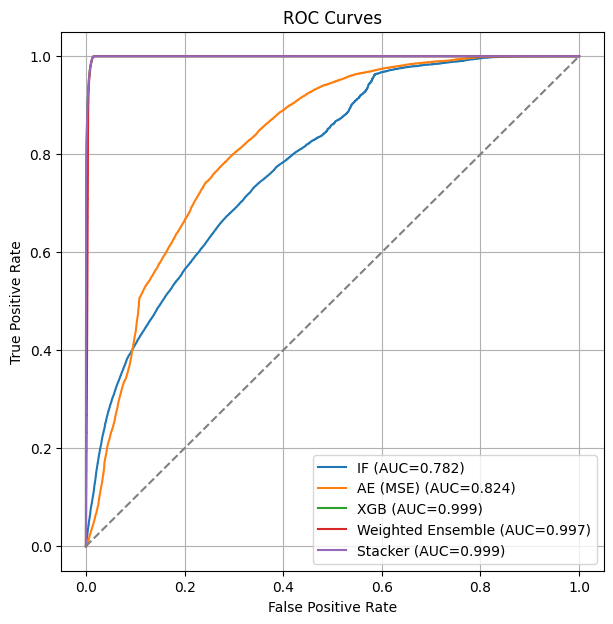

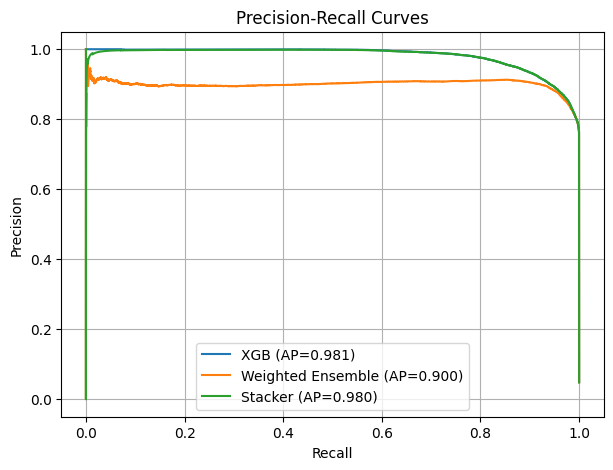

In [11]:

plt.figure(figsize=(7,7))
for label, score in [
    ("IF", if_scores_test),
    ("AE (MSE)", ae_mse_test),
    ("XGB", xgb_proba_test),
    ("Weighted Ensemble", combined_score),
    ("Stacker", stack_pred_test_proba)
]:
    fpr, tpr, _ = roc_curve(y_test, score)
    auc = roc_auc_score(y_test, score)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(); plt.show()

# Precision-Recall curve for best ensemble vs XGB
plt.figure(figsize=(7,5))
for label, score in [("XGB", xgb_proba_test), ("Weighted Ensemble", combined_score), ("Stacker", stack_pred_test_proba)]:
    prec, rec, _ = precision_recall_curve(y_test, score)
    ap = average_precision_score(y_test, score)
    plt.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curves"); plt.legend(); plt.grid(); plt.show()


#  8) Save ensemble outputs and meta-model

In [12]:

out_df = pd.DataFrame({
    "if_score": if_scores_test,
    "if_pred": if_pred_test,
    "ae_mse": ae_mse_test,
    "ae_pred_95pct": ae_pred_test_default,
    "xgb_proba": xgb_proba_test,
    "xgb_pred": xgb_pred_test,
    "maj_vote": majority_vote_pred,
    "weighted_vote": weighted_vote_pred,
    "stacker_proba": stack_pred_test_proba,
    "stacker_pred": stack_pred_test,
    "y_test": y_test
})
out_df.to_pickle(OUT_DIR / "unsw_ensemble_test_results.pkl")
print("Saved ensemble test results to:", OUT_DIR / "unsw_ensemble_test_results.pkl")

joblib.dump(stacker, MODEL_DIR / "unsw_ensemble_stacker_lr_v1.pkl")
print("Saved stacker model to:", MODEL_DIR / "unsw_ensemble_stacker_lr_v1.pkl")


Saved ensemble test results to: /content/drive/MyDrive/zeusOps/data/UNSW-NB15/unsw_ensemble_test_results.pkl
Saved stacker model to: /content/drive/MyDrive/zeusOps/models/unsw_ensemble_stacker_lr_v1.pkl


#  9) Quick summary numbers

In [13]:

print("\nSummary counts:")
print("Test samples:", len(y_test))
print("Ground-truth attacks:", int(y_test.sum()))
print("Pred attacks (XGB):", int(xgb_pred_test.sum()), "Pred attacks (IF):", int(if_pred_test.sum()))
print("Pred attacks (AE 95pct):", int(ae_pred_test_default.sum()))
print("Pred attacks (majority):", int(majority_vote_pred.sum()))
print("Pred attacks (weighted):", int(weighted_vote_pred.sum()))
print("Pred attacks (stacker):", int(stack_pred_test.sum()))



Summary counts:
Test samples: 411883
Ground-truth attacks: 19929
Pred attacks (XGB): 25860 Pred attacks (IF): 29467
Pred attacks (AE 95pct): 20741
Pred attacks (majority): 16788
Pred attacks (weighted): 21240
Pred attacks (stacker): 24833
